In [305]:
# Imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from langdetect import detect
import pickle

### Loading the Data

In [208]:
with open('reviews10k.json') as f:
    data = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")

In [209]:
df = pd.DataFrame(data)

In [210]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,1412998442000
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,1435955905000
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,1369773486000
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,1262917755000
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,1311876301000


### Exploratory Data Analysis

In [211]:
# Look at the distribution of stars
stars_distribution = df['stars'].value_counts()
stars_distribution

5    42173
4    25523
3    11908
1    11748
2     8648
Name: stars, dtype: int64

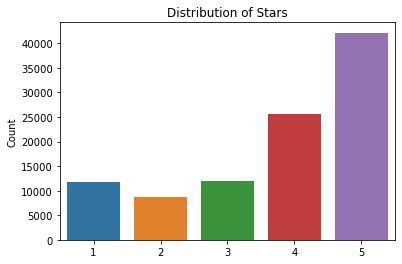

In [212]:
ax = sns.barplot(x=stars_distribution.index, y=stars_distribution.values)
ax.set(ylabel="Count")
plt.title('Distribution of Stars')
plt.show()

Overall, the stars ratings are skewed towards the upper limit. Majority of the reviews have ratings of 4 or 5.

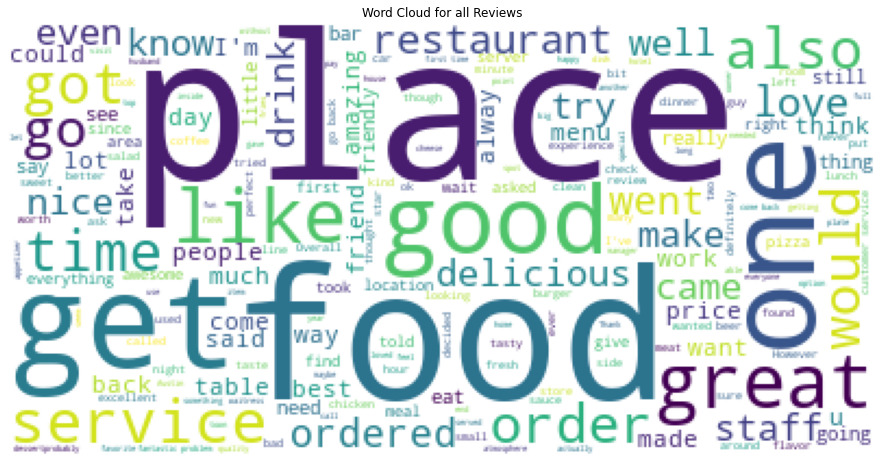

In [213]:
# Word cloud

# Get stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Combine all reviews into 1 single string
combined_review_text = ' '.join(df['text'])

# Create word cloud without stopwords
wc = WordCloud(background_color='white', stopwords=stopwords).generate(combined_review_text)

plt.figure(figsize=(16,8))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud for all Reviews")
plt.show()

Top words include "food", "restaurant", "delicious", etc, suggesting that majority of the businesses in the dataset are food businesses. There are seem to be frequent occurrences of positive words like "good" and "great", suggesting that majority of the reviews are positive, which is in line with the stars distribution. However, we cannot readily conclude as such yet, because there may also be high occurrences of phrases like "not good", which are negative.

### Data Cleaning

Add labels to our dataset. We consider reviews of ratings 4 and 5 to be "positive" (1) and reviews of ratings 1 and 2 to be "negative". We shall ignore and remove reviews of rating 3.

In [214]:
# Remove stars = 3
df = df[df['stars'] != 3]

In [215]:
# set sentiment = 1 (positive) or 0 (negative) depending on stars
df['sentiment'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

In [216]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,1412998442000,1
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,1435955905000,1
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,1369773486000,1
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,1262917755000,0
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,1311876301000,1


In [217]:
# Drop the unnecessary columns (we only need text and sentiment)
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,Apparently Prides Osteria had a rough summer a...,1
1,This store is pretty good. Not as great as Wal...,1
2,I called WVM on the recommendation of a couple...,1
3,I've stayed at many Marriott and Renaissance M...,0
4,The food is always great here. The service fro...,1


Since there might be reviews of different languages, we want to remove non-english reviews.

In [228]:
# Find the non-english reviews
non_english = df[df['text'].apply(detect)!='en']

In [229]:
non_english

,text,sentiment
1706,Uno dei pochi ristoranti nel quartiere aperti ...,1
4480,"Demais! Todas as atendentes são brasileiras, a...",1
4942,In this Argentine inn you have to make a reser...,0
5991,Tender and flavorful beef brisket and ribs. Br...,1
7213,いつもLAからラスベガスに行く途中のお楽しみが、オースティンにあった！！生のポテトを使ったフ...,1
...,...,...
92948,Otima pizzaria de orlando!Bem do estilo americ...,1
95539,No me gusto para nada; desde que entras al lug...,0
96751,"Un hermoso lugar,con buena ambientación ( camb...",1
99498,"I'm Turkish, my grandfather is from North Cypr...",1


In [230]:
# Filter the df to contain only english reviews
df = df[df['text'].apply(detect)=='en']

In [234]:
# Reset the index of the df
df = df.reset_index(drop=True)

In [238]:
df

,text,sentiment
0,Apparently Prides Osteria had a rough summer a...,1
1,This store is pretty good. Not as great as Wal...,1
2,I called WVM on the recommendation of a couple...,1
3,I've stayed at many Marriott and Renaissance M...,0
4,The food is always great here. The service fro...,1
...,...,...
87960,I figured I would try this place based on so m...,0
87961,We were there for lunch on April 26th. We opte...,1
87962,Stopped in here after returning from a trip. A...,1
87963,Who doesn't love Wendy's! This one however is ...,1


### Exploratory Data Analysis II

In [239]:
# Do further word cloud analysis on the reviews which are positive and negative separately

# Split dataframe into positive and negative
positive_reviews_df = df[df['sentiment'] == 1]
negative_reviews_df = df[df['sentiment'] == 0]

# Combine reviews into single string
combined_positive_text = ' '.join(positive_reviews_df['text'])
combined_negative_text = ' '.join(negative_reviews_df['text'])

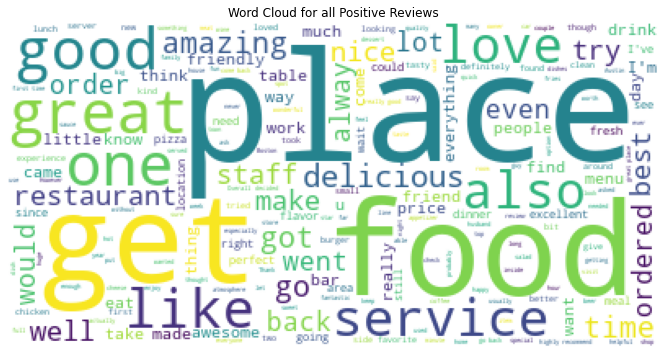

In [240]:
# Create positive word cloud
wc_positive = WordCloud(background_color='white', stopwords=stopwords).generate(combined_positive_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_positive)
plt.axis("off")
plt.title("Word Cloud for all Positive Reviews")
plt.show()

Word cloud for positive reviews looks very similar to the combined word cloud. Perhaps because majority of the reviews are positive.

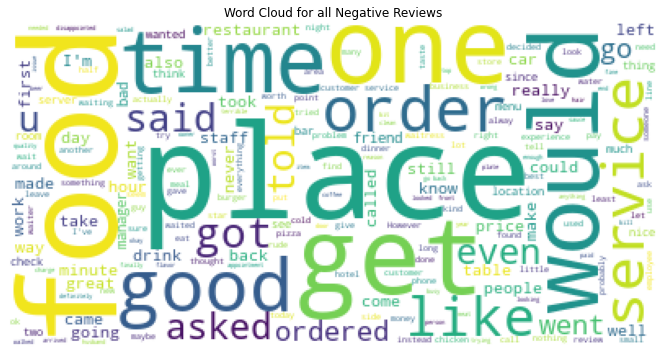

In [241]:
# Create negative word cloud
wc_negative = WordCloud(background_color='white', stopwords=stopwords).generate(combined_negative_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_negative)
plt.axis("off")
plt.title("Word Cloud for all Negative Reviews")
plt.show()

No obvious negative words in the word cloud. However, "good" was one of the top words. This likely indicates that "not good" was used frequently. Therefore, it would be important to consider bigrams in our sentiment classification.

### Data Preprocessing

We want to preprocess the data before using it to train the model.
- Lowercase
- Remove punctuation (excluding hyphens)
- Remove digits
- Tokenize
- Remove stopwords (excluding negation eg not)
- Stemming

In [242]:
# Lowercase
df["processed_text"] = df['text'].apply(lambda x: x.lower())
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,apparently prides osteria had a rough summer a...
1,This store is pretty good. Not as great as Wal...,1,this store is pretty good. not as great as wal...
2,I called WVM on the recommendation of a couple...,1,i called wvm on the recommendation of a couple...
3,I've stayed at many Marriott and Renaissance M...,0,i've stayed at many marriott and renaissance m...
4,The food is always great here. The service fro...,1,the food is always great here. the service fro...


In [243]:
# Remove punctuations except hyphens
punctuations = string.punctuation.replace('-', '')

# Function to remove punctuations
def remove_punctuation(text, punctuations):
    return text.translate(str.maketrans('', '', punctuations))

# Remove punctuation from all reviews
df['processed_text'] = df['processed_text'].apply(lambda x: remove_punctuation(x, punctuations))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,apparently prides osteria had a rough summer a...
1,This store is pretty good. Not as great as Wal...,1,this store is pretty good not as great as walm...
2,I called WVM on the recommendation of a couple...,1,i called wvm on the recommendation of a couple...
3,I've stayed at many Marriott and Renaissance M...,0,ive stayed at many marriott and renaissance ma...
4,The food is always great here. The service fro...,1,the food is always great here the service from...


In [244]:
# Remove digits
def remove_digits(text):
    return ''.join([i for i in text if not i.isdigit()])

# Remove digits from all reviews
df['processed_text'] = df['processed_text'].apply(lambda x: remove_digits(x))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,apparently prides osteria had a rough summer a...
1,This store is pretty good. Not as great as Wal...,1,this store is pretty good not as great as walm...
2,I called WVM on the recommendation of a couple...,1,i called wvm on the recommendation of a couple...
3,I've stayed at many Marriott and Renaissance M...,0,ive stayed at many marriott and renaissance ma...
4,The food is always great here. The service fro...,1,the food is always great here the service from...


In [245]:
# Tokenize the sentence
df['processed_text'] = df['processed_text'].apply(lambda x: word_tokenize(x))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,"[apparently, prides, osteria, had, a, rough, s..."
1,This store is pretty good. Not as great as Wal...,1,"[this, store, is, pretty, good, not, as, great..."
2,I called WVM on the recommendation of a couple...,1,"[i, called, wvm, on, the, recommendation, of, ..."
3,I've stayed at many Marriott and Renaissance M...,0,"[ive, stayed, at, many, marriott, and, renaiss..."
4,The food is always great here. The service fro...,1,"[the, food, is, always, great, here, the, serv..."


In [246]:
stopwords = nltk.corpus.stopwords.words('english')

In [247]:
# Remove stopwords

# Do not include negation (not, no) in the stopwords
stopwords.remove("not")
stopwords.remove("no")

# Function to remove stopwords
def remove_stopwords(text, stopwords):
    result = []
    for word in text:
        if word not in stopwords:
            result.append(word)
    return result

# Remove stopwords from reviews
df['processed_text'] = df['processed_text'].apply(lambda x: remove_stopwords(x, stopwords))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,"[apparently, prides, osteria, rough, summer, e..."
1,This store is pretty good. Not as great as Wal...,1,"[store, pretty, good, not, great, walmart, pre..."
2,I called WVM on the recommendation of a couple...,1,"[called, wvm, recommendation, couple, friends,..."
3,I've stayed at many Marriott and Renaissance M...,0,"[ive, stayed, many, marriott, renaissance, mar..."
4,The food is always great here. The service fro...,1,"[food, always, great, service, manager, well, ..."


In [248]:
# Stemming
ps = PorterStemmer()

def stemming(text, ps):
    return [ps.stem(word) for word in text]

# Stem the words in reviews
df['processed_text'] = df['processed_text'].apply(lambda x: stemming(x, ps))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,"[appar, pride, osteria, rough, summer, evidenc..."
1,This store is pretty good. Not as great as Wal...,1,"[store, pretti, good, not, great, walmart, pre..."
2,I called WVM on the recommendation of a couple...,1,"[call, wvm, recommend, coupl, friend, use, pas..."
3,I've stayed at many Marriott and Renaissance M...,0,"[ive, stay, mani, marriott, renaiss, marriott,..."
4,The food is always great here. The service fro...,1,"[food, alway, great, servic, manag, well, staf..."


In [249]:
# Combine processed text back into a single string
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))
df.head()

,text,sentiment,processed_text
0,Apparently Prides Osteria had a rough summer a...,1,appar pride osteria rough summer evidenc almos...
1,This store is pretty good. Not as great as Wal...,1,store pretti good not great walmart prefer mil...
2,I called WVM on the recommendation of a couple...,1,call wvm recommend coupl friend use past thoug...
3,I've stayed at many Marriott and Renaissance M...,0,ive stay mani marriott renaiss marriott huge d...
4,The food is always great here. The service fro...,1,food alway great servic manag well staff super...


### Training of Model

1. Sampling the dataset - Since the dataset is very large, we want to train and test the model on a smaller dataset. We will sample a portion of the dataset, ensuring equal distribution of positive and negative reviews

2. Train-test split on the dataset

3. Convert text into bag-of-words (BoW), i.e. represent words in numbers, using CountVectorizer

4. Train the model (Logistic Regression)

In [250]:
# Sample the dataset
positive_count = 10000
negative_count = 10000

# Get the rows for positive and negative reviews
positive_reviews = df[df['sentiment'] == 1]
negative_reviews = df[df['sentiment'] == 0]

# Sample the positive and negative reviews
positive_sample_reviews = positive_reviews.sample(n=positive_count).reset_index(drop=True)
negative_sample_reviews = negative_reviews.sample(n=negative_count).reset_index(drop=True)

# Merge the dataframes
merged_df = pd.concat([positive_sample_reviews, negative_sample_reviews]).reset_index(drop=True)

In [251]:
# Train test split
x = merged_df['processed_text']
y= merged_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [252]:
# CountVectorizer - bigram
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit the training data
train_matrix = vectorizer.fit_transform(X_train)
test_matrix = vectorizer.transform(X_test)

In [253]:
vectorizer.get_feature_names_out()

array(['aa choic', 'aa conveni', 'aa employe', ..., '人餐 tire', '人餐 人餐',
       '小肥牛 finish'], dtype=object)

In [255]:
# Logistic Regression

# Fit
lr = LogisticRegression()
lr.fit(train_matrix, y_train)

LogisticRegression()

### Testing the Model

In [256]:
# Testing
y_pred = lr.predict(test_matrix)

In [257]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[2557,  426],
       [ 252, 2765]], dtype=int64)

In [258]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2983
           1       0.87      0.92      0.89      3017

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



### Export the Model and Vectorizer

In [306]:
with open("modelAndVectorizer.pkl", 'wb') as fout:
    pickle.dump((lr, vectorizer), fout)

In [314]:
# Code to read model and vectorizer -> use this in the application

with open('modelAndVectorizer.pkl', 'rb') as f:
    lr, vectorizer = pickle.load(f)